<a href="https://colab.research.google.com/github/ycnnn/STAT542/blob/main/Coding_1/542_Coding_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
#Final version

import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as knn


# Set seed as the last 4 digits of my UIN
np.random.seed(9367)

p = 2
csize = 10
sigma = 1
m0_mean = [0,1]
m1_mean = [1,0]
cov = [[1,0],[0,1]]
n_sim = 50

m1 = np.random.normal(size = (csize, p)) * sigma + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * sigma + np.concatenate([np.array([[0, 1]] * csize)]) # generate center m1

class sim_params :
    csize = 10           # number of centers
    p = 2                # dimension
    s = np.sqrt(1 / 5)   # standard deviation for generating data
    n = 100              # training size per class
    N = 5000             # test size per class
    m0 = m0              # 10 centers for class 0
    m1 = m1              # 10 centers for class 1

def generate_sim_data(sim_params):

    p = sim_params.p
    s = sim_params.s
    n = sim_params.n
    N = sim_params.N
    m1 = sim_params.m1
    m0 = sim_params.m0
    csize = sim_params.csize
    
    id1 = np.random.randint(csize, size = n)
    id0 = np.random.randint(csize, size = n)

    Xtrain = np.random.normal(size = (2 * n, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    Ytrain = np.concatenate(([1]*n, [0]*n))

    id1 = np.random.randint(csize, size = N)
    id0 = np.random.randint(csize, size = N)
    Xtest = np.random.normal(size = (2 * N, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    Ytest = np.concatenate(([1]*N, [0]*N))

    return Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain, Xtest, Ytest = generate_sim_data(sim_params)

#Generating 50 test samples
XtrainSim = np.zeros((n_sim,2 * sim_params.n,sim_params.p))
YtrainSim = np.zeros((n_sim,2 * sim_params.n))
XtestSim = np.zeros((n_sim,2 * sim_params.N,sim_params.p))
YtestSim = np.zeros((n_sim,2 * sim_params.N))

for i in range(n_sim):
  XtrainSim[i], YtrainSim[i], XtestSim[i], YtestSim[i] = generate_sim_data(sim_params)

######################################################################
# new code
# k is knn n searching parameter
def myknn(xtrain, ytrain, xtest, k):
  y_pred = np.array([])
  for element in xtest:
    # matrix: first row = distance, second row = corresponding y training value
    matrix = np.vstack((LA.norm(xtrain-element, axis=1).transpose(),
                        ytrain[np.newaxis])).transpose()
    # final: sorted matrix based on distance.
    final = matrix[matrix[:, 0].argsort()]
    # y_searched: y value list, from nearested to farest
    y_searched = final[:,1]
    #print(y_searched)
    # y_pred: average of first n nearest results
    y_topk = np.sum(y_searched[0:k])/k
    y_pred = np.append(y_pred, y_topk)
    #voting: if predicted y >= 0.5 then predict 1
  return np.where(y_pred >= 0.5, 1,0) 





###############################################################################
#Adding knn_predict

################################################################################
#cv-knn
def cvknn(xtrain, ytrain, num_folds, k):
  indices = np.arange(len(ytrain))
  np.random.shuffle(indices)
  index_sets = np.array_split(indices, num_folds)
  error = 0

  for ifold in range(num_folds):
    train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
    _traindata = xtrain[train_indices]
    _Ytrain = ytrain[train_indices]
    
    test_indices = index_sets[ifold]
    _testdata = xtrain[test_indices]
    _Ytest = ytrain[test_indices]

    error += (np.sum(myknn(_traindata, _Ytrain, _testdata, k) != _Ytest)/num_folds)/len(_Ytest)
  
  return error
    
  


##################################################################################
#Bayes rule
def bayes(x):
  y_pred_bayes = np.array([])
  for element in x:
    d1 = sum(np.exp(- ((m1[i, 0] - element[0]) ** 2 + (m1[i, 1] - element[1]) ** 2) / (2 * sim_params.s ** 2)) for i in range(len(m1)))
    d0 = sum(np.exp(- ((m0[i, 0] - element[0]) ** 2 + (m0[i, 1] - element[1]) ** 2) / (2 * sim_params.s ** 2)) for i in range(len(m0)))
    y_pred_bayes = np.append(y_pred_bayes, d1/d0)
  return np.where(y_pred_bayes >= 1, 1,0)
 

#################################################################################
#find best k @10-folds cv-knn
cv_result = np.vstack((np.arange(1,181), np.array([cvknn(Xtrain, Ytrain, 10, k) for k in range(1,181)]))).transpose()
best_k = int(cv_result[cv_result[:, 1].argsort()][0,0])
#k = 13

 

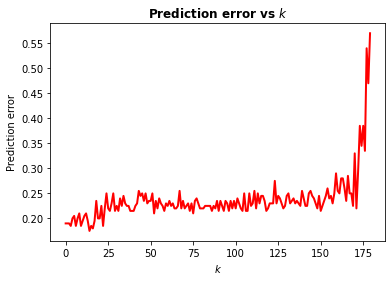

In [131]:
##################################################################################
#Plot error rate vs k
plt.plot(np.array([cvknn(Xtrain, Ytrain, 10, k) for k in range(1,181)]), linewidth = 2, color = "r")
plt.title("Prediction error vs $k$", fontweight="bold", loc='center', pad=None)
plt.xlabel("$k$")
plt.ylabel("Prediction error")
plt.savefig('AccuracyVsK.png', dpi=800)

In [165]:
###############################################################################
#TestTest your code with mydata when K = 1, 3, 5; 
#compare your results with the ones from the R command knn.

#k = 1
#My KNN model
k_1 = myknn(Xtrain, Ytrain, Xtest, 1) 
#KNN model from SKLearn
model_k_1 = knn(n_neighbors= 1)
model_k_1.fit(Xtrain,Ytrain)
sk_k_1 = model_k_1.predict(Xtest) 
#Print results
print(pd.crosstab(k_1, Ytest))
print(pd.crosstab(sk_k_1, Ytest))


col_0     0     1
row_0            
0      4018  1027
1       982  3973
col_0     0     1
row_0            
0      4018  1027
1       982  3973


In [166]:
#k = 3
#My KNN model
k_3 = myknn(Xtrain, Ytrain, Xtest, 3) 
#KNN model from SKLearn
model_k_3 = knn(n_neighbors= 3)
model_k_3.fit(Xtrain,Ytrain)
sk_k_3 = model_k_3.predict(Xtest) 
#Print results
print(pd.crosstab(k_3, Ytest))
print(pd.crosstab(sk_k_3, Ytest))


col_0     0     1
row_0            
0      4064   873
1       936  4127
col_0     0     1
row_0            
0      4064   873
1       936  4127


In [167]:
#k = 5
#My KNN model
k_5 = myknn(Xtrain, Ytrain, Xtest, 5) 
#KNN model from SKLearn
model_k_5 = knn(n_neighbors= 5)
model_k_5.fit(Xtrain,Ytrain)
sk_k_5 = model_k_5.predict(Xtest) 
#Print results
print(pd.crosstab(k_5, Ytest))
print(pd.crosstab(sk_k_5, Ytest))


col_0     0     1
row_0            
0      4057   803
1       943  4197
col_0     0     1
row_0            
0      4057   803
1       943  4197


In [181]:
###############################################################################
#Simulation study, KNN @ k=1
err_knn = []
err_best_k = []
err_bayes = []
length = len(YtestSim[i])

for i in range(n_sim):

  err_knn.append(np.sum(myknn(Xtrain, Ytrain, XtestSim[i], 1) != YtestSim[i])/length)


  err_best_k.append(np.sum(myknn(Xtrain, Ytrain, XtestSim[i], best_k) != YtestSim[i])/length)


  err_bayes.append(np.sum(bayes(XtestSim[i]) != YtestSim[i])/length)

In [190]:
print(f"For k = 1, the mean error is {np.mean(err_knn):.3f}, standard deviation is {np.std(err_knn):.6f}")
print(f"For best k from cv-knn, the mean error is {np.mean(err_best_k):.3f}, standard deviation is {np.std(err_best_k):.6f}")
print(f"For Bayes risk, the mean error is {np.mean(err_bayes):.3f}, standard deviation is {np.std(err_bayes):.6f}")


For k = 1, the mean error is 0.204, standard deviation is 0.003989
For best k from cv-knn, the mean error is 0.154, standard deviation is 0.003657
For Bayes risk, the mean error is 0.139, standard deviation is 0.003833
